# Using Hugging Face model RoBERTa
RoBERTa(A Robustly Optimized BERT Pretraining Approach)

### Import utilities

In [147]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from tqdm.notebook import tqdm
import re

from collections import Counter

import nltk
from nltk.corpus import stopwords 
from nltk.tokenize import word_tokenize 
from collections import Counter 

nltk.download('punkt_tab')
nltk.download('stopwords') 

plt.style.use('ggplot')

[nltk_data] Downloading package punkt_tab to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /teamspace/studios/this_studio/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Load cleaned dataset

In [148]:
data = pd.read_csv('/teamspace/studios/this_studio/PROJECT_FINAL/mcdonalds_reviews/cleaned_data.csv')
data.head()

,reviewer_id,latitude,longitude,rating,review_date,City,State,clean_reviews,actual_sentiment
0,1,30.460718,-97.792874,1,2025-01-05,Austin,TX 78750,Why does it look like someone spit on my food ...,negative
1,2,30.460718,-97.792874,4,2025-03-31,Austin,TX 78750,Itd McDonalds It is what it is as far as the f...,positive
2,3,30.460718,-97.792874,1,2025-03-31,Austin,TX 78750,Made a mobile order got to the speaker and che...,negative
3,4,30.460718,-97.792874,5,2025-03-05,Austin,TX 78750,My mc Crispy chicken sandwich was customer ser...,positive
4,5,30.460718,-97.792874,1,2025-02-05,Austin,TX 78750,I repeat my order times in the drive thru and ...,negative


## Quick EDA

In [149]:
df = data.copy()

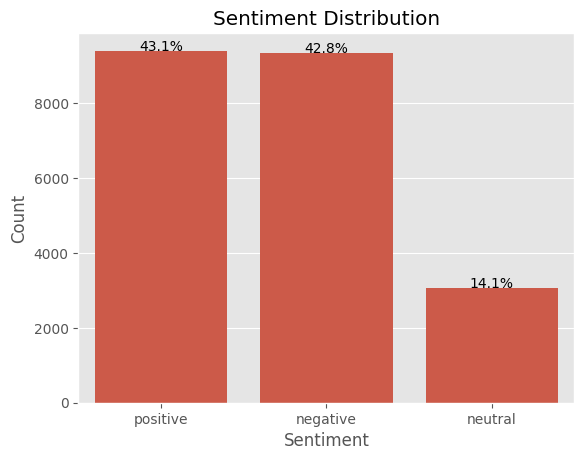

In [150]:
# Sentiment distribution on the dataset
sentiment_distribution = df['actual_sentiment'].value_counts()
total = sentiment_distribution.sum()

sns.barplot(x=sentiment_distribution.index, y=sentiment_distribution.values)

for i, val in enumerate(sentiment_distribution.values):
    plt.text(i, val + 1, f'{(val/total)*100:.1f}%', ha='center')

plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


# Load RoBERTa Pretrained Model

    - Use a model trained of a large corpus of data.
    - Transformer model accounts for the words but also the context related to other words.


In [131]:
# Load model 
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification

model_name = "cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

# Create sentiment analysis pipeline
model_roberta = pipeline("sentiment-analysis", model=model,tokenizer=tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Device set to use cpu


In [200]:
# Load model directly
from transformers import AutoTokenizer, AutoModelForSequenceClassification

tokenizer = AutoTokenizer.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")
model = AutoModelForSequenceClassification.from_pretrained("cardiffnlp/twitter-roberta-base-sentiment-latest")

model_roberta = pipeline("sentiment-analysis", model=model,tokenizer=tokenizer)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
Some weights of the model checkpoint at cardiffnlp/twitter-roberta-base-sentiment-latest were not used when initializing RobertaForSequenceClassification: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a

Error during conversion: ChunkedEncodingError(ProtocolError('Response ended prematurely'))


### Test model on Mcdonald's restaurants in New York

In [161]:
# Use model to analyze reviews of Mcdonald's restaurants in New York
df1 = df.copy()
df_newyork=df1[df1["City"]=="New York"]

In [162]:
# Create dataframe of review_id, review, ratings, actual_review
df_newyork=df_newyork[['reviewer_id','clean_reviews','actual_sentiment']]

In [163]:
df_newyork.head()

,reviewer_id,clean_reviews,actual_sentiment
2020,2969,Visited this location for breakfast The place ...,neutral
2021,2970,From cleanliness to freshness to the fast cust...,positive
2022,2971,McDonalds was great The food tastes like in Uk...,positive
2023,2972,Thursday at am I went in here to order A very ...,negative
2024,2973,It is a hr location when I arrived and tried t...,negative


In [164]:
# Loop to each review in the dataset, the results are stored in a dictionary
res = {}
for i, row in tqdm(df_newyork.iterrows(), total=len(df_newyork)):
    try:
        text = row['clean_reviews']
        myid = row['reviewer_id']

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBERTa_{key}'] = value

        res[myid] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/2586 [00:00<?, ?it/s]

In [180]:
# Convert the results in dictionary to pandas DataFrame
results = pd.DataFrame(res).T
results= results.reset_index().rename(columns={'index': 'reviewer_id','RoBERTa_label': 'pred_sentiment'})
results.head()

,reviewer_id,pred_sentiment,RoBERTa_score
0,2969,positive,0.875629
1,2970,positive,0.902563
2,2971,positive,0.982394
3,2972,negative,0.8198
4,2973,negative,0.829728


In [181]:
# Merge the results dataframe to the main dataframe of Mcdonalds Newyork
df_results = results.merge(df_newyork, how='left')
df_results.head()

,reviewer_id,pred_sentiment,RoBERTa_score,clean_reviews,actual_sentiment
0,2969,positive,0.875629,Visited this location for breakfast The place ...,neutral
1,2970,positive,0.902563,From cleanliness to freshness to the fast cust...,positive
2,2971,positive,0.982394,McDonalds was great The food tastes like in Uk...,positive
3,2972,negative,0.8198,Thursday at am I went in here to order A very ...,negative
4,2973,negative,0.829728,It is a hr location when I arrived and tried t...,negative


In [167]:
# RoBERTa labeled results as: for negative review as LABEL_0, for neutral as LABEL_1, and for positive as LABEL_2
# Below is to map  the Labels as negative , neutral and positive

#def map_roberta_labels(label):
 #   if label == 'LABEL_0':
 #       return 'negative'
  #  elif label == 'LABEL_1':
   #     return 'neutral'
    #elif label == 'LABEL_2':
      #  return 'positive'
    #else:
     #   return 'unknown' 

# Apply the function to the 'RoBerta_label' column
#results['predicted_sentiment'] = results['RoBERTa_label'].apply(map_roberta_labels)

In [168]:
#df_results =results[['reviewer_id', 'clean_reviews', 'RoBERTa_label', 'predicted_sentiment']]

In [182]:
df_results['clean_reviews'][4]

'It is a hr location when I arrived and tried to order use the restroom I was told the restroom was closed I said I will order right after my use of the restroom but they still rejected with rude attitude I already told them Im having shivers and can'

In [183]:
df_results['RoBERTa_score'] = df_results['RoBERTa_score'].astype(float)

In [184]:
df_results.describe(include='all')

,reviewer_id,pred_sentiment,RoBERTa_score,clean_reviews,actual_sentiment
count,2586.000000,2586,2586.000000,2586,2586
unique,NaN,3,NaN,2586,3
top,NaN,negative,NaN,Having good experience on my recent visit crew...,positive
freq,NaN,1100,NaN,1,1194
mean,5127.601315,NaN,0.799297,NaN,NaN
std,1518.308440,NaN,0.161002,NaN,NaN
min,2969.000000,NaN,0.339242,NaN,NaN
25%,3682.250000,NaN,0.677687,NaN,NaN
50%,4755.500000,NaN,0.856386,NaN,NaN
75%,6353.750000,NaN,0.934841,NaN,NaN


In [185]:
print(df_results[['RoBERTa_score', 'pred_sentiment', 'actual_sentiment']].head(5))

   RoBERTa_score pred_sentiment actual_sentiment
0       0.875629       positive          neutral
1       0.902563       positive         positive
2       0.982394       positive         positive
3       0.819800       negative         negative
4       0.829728       negative         negative


In [186]:
# Function to calculate accuracy
def calculate_accuracy(predicted_labels, actual_labels):
    correct = 0
    total = 0
    for pred, actual in zip(predicted_labels, actual_labels):
        if pred is not None:  
            total += 1
            if pred.lower() == actual.lower():  
                correct += 1
    return correct / total if total > 0 else 0.0  

In [187]:
# Calculate accuracy
accuracy = calculate_accuracy(df_results['pred_sentiment'], df_results['actual_sentiment'])
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.70


In [188]:
df_results['correct_prediction'] = df_results.apply(
    lambda row: True if row['pred_sentiment'] == row['actual_sentiment'] else False,
    axis=1
)

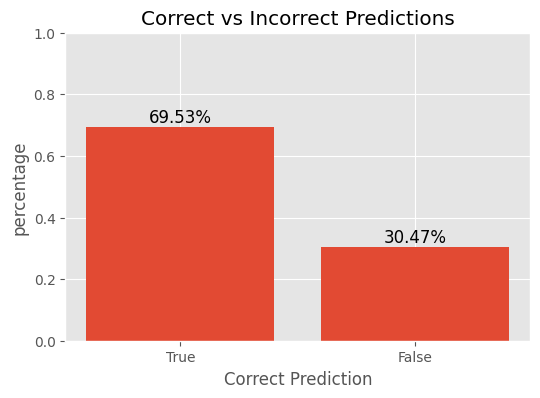

In [189]:
# Calculate percentage
percentage = df_results['correct_prediction'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percentage.index.astype(str), percentage.values)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2%}',
        ha='center', va='bottom', fontsize=12
    )

plt.xlabel('Correct Prediction')
plt.ylabel('percentage')
plt.title('Correct vs Incorrect Predictions')
plt.ylim(0, 1)
plt.show()


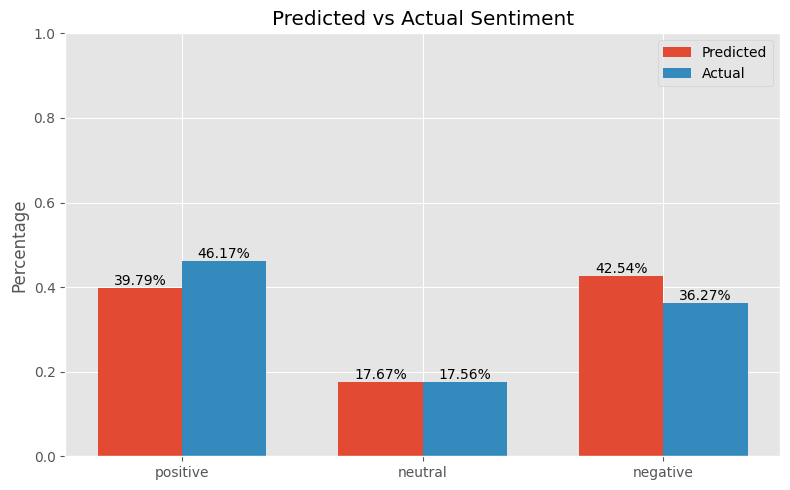

In [190]:
# List of sentiments
sentiment = ['positive', 'neutral','negative']

# Calculation proportions
total_predicted = df_results['pred_sentiment'].value_counts(normalize=True)
total_actual = df_results['actual_sentiment'].value_counts(normalize=True)

predicted_props = [total_predicted.get(label, 0) for label in sentiment]
actual_props = [total_actual.get(label, 0) for label in sentiment]

# Bar
x = range(len(sentiment))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - bar_width/2 for i in x], predicted_props, width=bar_width, label='Predicted')
bars2 = plt.bar([i + bar_width/2 for i in x], actual_props, width=bar_width, label='Actual')

# Add percentage labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10
        )

plt.xticks(ticks=x, labels=sentiment)
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.title('Predicted vs Actual Sentiment')
plt.legend()
plt.tight_layout()
plt.show()


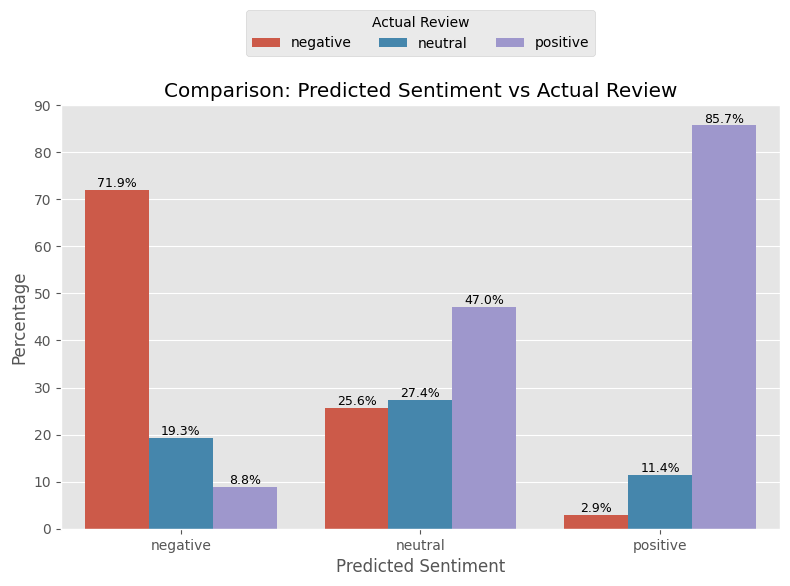

In [191]:
df_results_filtered = df_results.copy()  

# Group and compute percentages
rates = df_results_filtered.groupby(['pred_sentiment', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='pred_sentiment', value_name='percentage', var_name='actual_sentiment')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='pred_sentiment', y='percentage', hue='actual_sentiment')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: Predicted Sentiment vs Actual Review')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


# Make predictions on the whole dataset

In [206]:
df2 = df.copy(deep=True)
df2 = df2.dropna(subset=['clean_reviews'])

In [207]:
# Create dataframe of review_id, review, ratings, actual_review
df_whole_dataset=df2[['reviewer_id','clean_reviews','rating','actual_sentiment']]
df_whole_dataset.head()

,reviewer_id,clean_reviews,rating,actual_sentiment
0,1,Why does it look like someone spit on my food ...,1,negative
1,2,Itd McDonalds It is what it is as far as the f...,4,positive
2,3,Made a mobile order got to the speaker and che...,1,negative
3,4,My mc Crispy chicken sandwich was customer ser...,5,positive
4,5,I repeat my order times in the drive thru and ...,1,negative


In [209]:
# Loop to each review in the dataset, the results are stored in a dictionary
res = {}
for i, row in tqdm(df_whole_dataset.iterrows(), total=len(df_whole_dataset)):
    try:
        text = row['clean_reviews']
        myid = row['reviewer_id']

        roberta_result = model_roberta(text)
        roberta_result_model = {}

        if isinstance(roberta_result, list) and len(roberta_result) > 0:
            for key, value in roberta_result[0].items():
                roberta_result_model[f'RoBERTa_{key}'] = value

        res[myid] = roberta_result_model

    except RuntimeError:
        print(f'Runtime error for id {myid}')

  0%|          | 0/21814 [00:00<?, ?it/s]

Runtime error for id 17317
Runtime error for id 23022
Runtime error for id 23690


In [210]:
# Convert the results in dictionary to pandas DataFrame
results_df = pd.DataFrame(res).T
results_df.head()

,RoBERTa_label,RoBERTa_score
1,negative,0.917278
2,positive,0.972301
3,negative,0.661857
4,positive,0.940411
5,negative,0.913123


In [211]:
results_df= results_df.reset_index().rename(columns={'index': 'reviewer_id','RoBERTa_label': 'pred_sentiment'})
results_df.head()


,reviewer_id,pred_sentiment,RoBERTa_score
0,1,negative,0.917278
1,2,positive,0.972301
2,3,negative,0.661857
3,4,positive,0.940411
4,5,negative,0.913123


In [212]:
# Merge the results dataframe to the main dataframe of Mcdonalds Newyork
results_df = results_df.merge(df_whole_dataset, how='left')
results_df.head()


,reviewer_id,pred_sentiment,RoBERTa_score,clean_reviews,rating,actual_sentiment
0,1,negative,0.917278,Why does it look like someone spit on my food ...,1,negative
1,2,positive,0.972301,Itd McDonalds It is what it is as far as the f...,4,positive
2,3,negative,0.661857,Made a mobile order got to the speaker and che...,1,negative
3,4,positive,0.940411,My mc Crispy chicken sandwich was customer ser...,5,positive
4,5,negative,0.913123,I repeat my order times in the drive thru and ...,1,negative


In [214]:
print(results_df[['RoBERTa_score', 'pred_sentiment', 'actual_sentiment']].head(10))

  RoBERTa_score pred_sentiment actual_sentiment
0      0.917278       negative         negative
1      0.972301       positive         positive
2      0.661857       negative         negative
3      0.940411       positive         positive
4      0.913123       negative         negative
5      0.902684       negative         negative
6      0.595205       negative         negative
7      0.798427        neutral         negative
8      0.889798       negative         negative
9      0.960698       positive         positive


In [215]:
# Calculate accuracy using the calculate_accuracy funtion
accuracy = calculate_accuracy(results_df['pred_sentiment'], results_df['actual_sentiment'])
print(f"Model Accuracy: {accuracy:.2f}")

Model Accuracy: 0.74


In [216]:
results_df['correct_prediction'] = results_df.apply(
    lambda row: True if row['pred_sentiment'] == row['actual_sentiment'] else False,
    axis=1
)

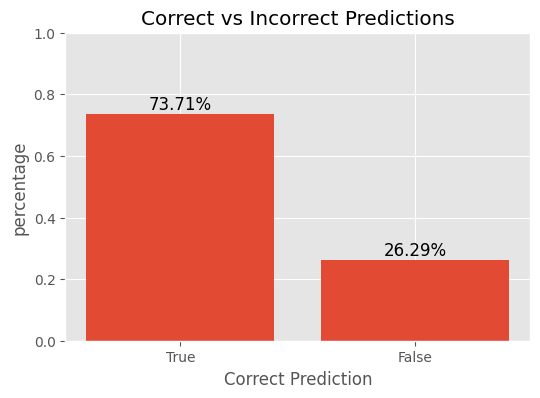

In [217]:
# Calculate percentage
percentage = results_df['correct_prediction'].value_counts(normalize=True)

# Plot
plt.figure(figsize=(6, 4))
bars = plt.bar(percentage.index.astype(str), percentage.values)

# Add percentage labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        height,
        f'{height:.2%}',
        ha='center', va='bottom', fontsize=12
    )

plt.xlabel('Correct Prediction')
plt.ylabel('percentage')
plt.title('Correct vs Incorrect Predictions')
plt.ylim(0, 1)
plt.show()


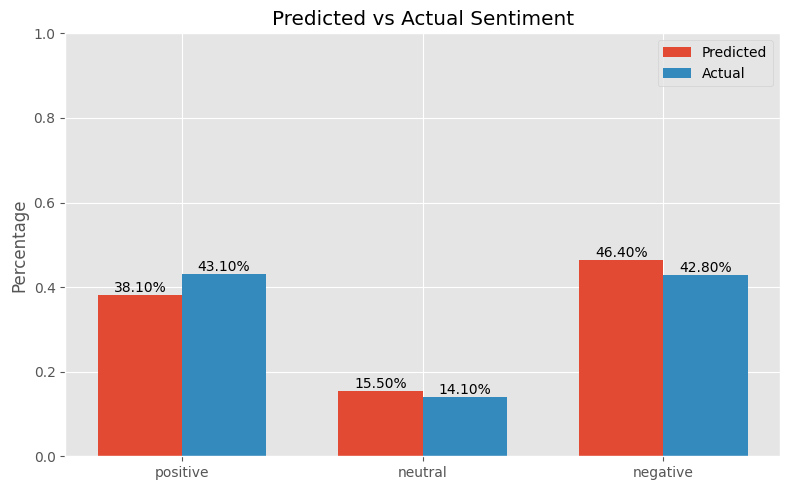

In [218]:
# List of sentiments
sentiment = ['positive', 'neutral','negative']

# Calculation proportions
total_predicted = results_df['pred_sentiment'].value_counts(normalize=True)
total_actual = results_df['actual_sentiment'].value_counts(normalize=True)

predicted_props = [total_predicted.get(label, 0) for label in sentiment]
actual_props = [total_actual.get(label, 0) for label in sentiment]

# Bar
x = range(len(sentiment))
bar_width = 0.35

# Plot
plt.figure(figsize=(8, 5))
bars1 = plt.bar([i - bar_width/2 for i in x], predicted_props, width=bar_width, label='Predicted')
bars2 = plt.bar([i + bar_width/2 for i in x], actual_props, width=bar_width, label='Actual')

# Add percentage labels on top of bars
for bars in [bars1, bars2]:
    for bar in bars:
        height = bar.get_height()
        plt.text(
            bar.get_x() + bar.get_width()/2,
            height,
            f'{height:.2%}',
            ha='center', va='bottom', fontsize=10
        )

plt.xticks(ticks=x, labels=sentiment)
plt.ylabel('Percentage')
plt.ylim(0, 1)
plt.title('Predicted vs Actual Sentiment')
plt.legend()
plt.tight_layout()
plt.show()


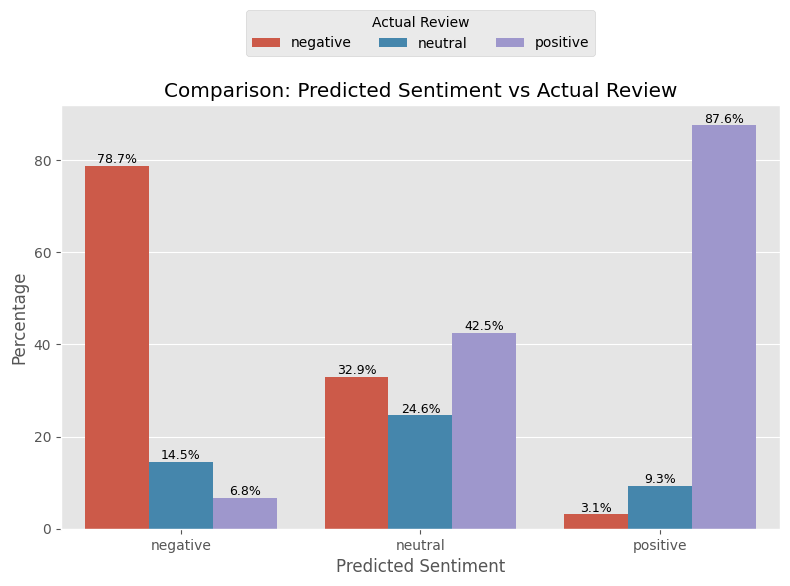

In [219]:
df_results_filtered = results_df.copy()  

# Group and compute percentages
rates = df_results_filtered.groupby(['pred_sentiment', 'actual_sentiment']).size().unstack().fillna(0)
rates = rates.div(rates.sum(axis=1), axis=0) * 100

# Convert to long format
rates_long = rates.reset_index().melt(id_vars='pred_sentiment', value_name='percentage', var_name='actual_sentiment')

# Barplot
plt.figure(figsize=(8, 6))
ax = sns.barplot(data=rates_long, x='pred_sentiment', y='percentage', hue='actual_sentiment')

# Add percentage labels on top of bars
for p in ax.patches:
    height = p.get_height()
    if height > 0:
        ax.annotate(f'{height:.1f}%', 
                    (p.get_x() + p.get_width() / 2., height), 
                    ha='center', va='bottom', fontsize=9)

plt.title('Comparison: Predicted Sentiment vs Actual Review')
plt.xlabel('Predicted Sentiment')
plt.ylabel('Percentage')
plt.legend(title='Actual Review', loc='lower center', bbox_to_anchor=(0.5, 1.1), ncol=3)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [220]:
# Merge results to the main dataset and remove the lines where errors occured on the prediction: 
df = df[~df['reviewer_id'].isin([17317,23022, 23690])]

In [221]:
# Merge results
df_results_merged = df_results_filtered.merge(df, how='left')
df_results_merged.head()


,reviewer_id,pred_sentiment,RoBERTa_score,clean_reviews,rating,actual_sentiment,correct_prediction,latitude,longitude,review_date,City,State
0,1,negative,0.917278,Why does it look like someone spit on my food ...,1,negative,True,30.460718,-97.792874,2025-01-05,Austin,TX 78750
1,2,positive,0.972301,Itd McDonalds It is what it is as far as the f...,4,positive,True,30.460718,-97.792874,2025-03-31,Austin,TX 78750
2,3,negative,0.661857,Made a mobile order got to the speaker and che...,1,negative,True,30.460718,-97.792874,2025-03-31,Austin,TX 78750
3,4,positive,0.940411,My mc Crispy chicken sandwich was customer ser...,5,positive,True,30.460718,-97.792874,2025-03-05,Austin,TX 78750
4,5,negative,0.913123,I repeat my order times in the drive thru and ...,1,negative,True,30.460718,-97.792874,2025-02-05,Austin,TX 78750


In [223]:
df_results_merged.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/mcdonalds_reviews/model_roberta_results.csv')

# Find common words

In [228]:
# Load RoBERTa results
df_roberta= pd.read_csv('/teamspace/studios/this_studio/PROJECT_FINAL/mcdonalds_reviews/model_roberta_results.csv').drop(columns='Unnamed: 0')
df_roberta.head(5)

,reviewer_id,pred_sentiment,RoBERTa_score,clean_reviews,rating,actual_sentiment,correct_prediction,latitude,longitude,review_date,City,State
0,1,negative,0.917278,Why does it look like someone spit on my food ...,1,negative,True,30.460718,-97.792874,2025-01-05,Austin,TX 78750
1,2,positive,0.972301,Itd McDonalds It is what it is as far as the f...,4,positive,True,30.460718,-97.792874,2025-03-31,Austin,TX 78750
2,3,negative,0.661857,Made a mobile order got to the speaker and che...,1,negative,True,30.460718,-97.792874,2025-03-31,Austin,TX 78750
3,4,positive,0.940411,My mc Crispy chicken sandwich was customer ser...,5,positive,True,30.460718,-97.792874,2025-03-05,Austin,TX 78750
4,5,negative,0.913123,I repeat my order times in the drive thru and ...,1,negative,True,30.460718,-97.792874,2025-02-05,Austin,TX 78750


In [229]:
df_roberta.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21811 entries, 0 to 21810
Data columns (total 12 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   reviewer_id         21811 non-null  int64  
 1   pred_sentiment      21811 non-null  object 
 2   RoBERTa_score       21811 non-null  float64
 3   clean_reviews       21811 non-null  object 
 4   rating              21811 non-null  int64  
 5   actual_sentiment    21811 non-null  object 
 6   correct_prediction  21811 non-null  bool   
 7   latitude            21162 non-null  float64
 8   longitude           21162 non-null  float64
 9   review_date         21503 non-null  object 
 10  City                21162 non-null  object 
 11  State               21162 non-null  object 
dtypes: bool(1), float64(3), int64(2), object(6)
memory usage: 1.9+ MB


In [242]:
# Remove Stopwords
def clean_review(review):
    if not isinstance(review, str): 
        return ""
    stop_words = set(stopwords.words('english'))
    stop_words.update(['mcdonalds', 'dont','go','got','even','good','one','always','get','like'])
    review_tokens = word_tokenize(review)
    filtered_review = ' '.join([word for word in review_tokens if word not in stop_words])

    return filtered_review

df_roberta['no_stop_words_review'] = df_roberta['clean_reviews'].str.lower().apply(clean_review)


In [243]:
df_roberta['word_list'] = df_roberta['no_stop_words_review'].apply(lambda x: str(x).split())
top_words = Counter([item for sublist in df_roberta['word_list'] for item in sublist])
top_words_df = pd.DataFrame(top_words.most_common(20), columns=['Common_words', 'count'])

top_words_df.style.background_gradient(cmap='Blues')

,Common_words,count
0,food,6078
1,service,4664
2,order,4662
3,place,2700
4,drive,2083
5,fast,2079
6,time,2035
7,staff,1922
8,great,1697
9,people,1627


## Common words in negative and positive reviews

In [244]:
positive = df_roberta[df_roberta['pred_sentiment'] == 'positive']
negative = df_roberta[df_roberta['pred_sentiment'] == 'negative']

In [245]:
# Word count in positive reviews
top = Counter([item for sublist in df_roberta[df_roberta['pred_sentiment'] == 'positive']['word_list'] for item in sublist])
positive_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
positive_words.style.background_gradient(cmap='Greens')

,Common_words,count
0,food,2371
1,service,2076
2,great,1462
3,fast,1367
4,clean,1140
5,place,1138
6,nice,901
7,staff,865
8,friendly,861
9,order,811


In [246]:
positive_words.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/mcdonalds_reviews/positive_words.csv')

In [247]:
# Word count in negative reviews
top = Counter([item for sublist in df_roberta[df_roberta['pred_sentiment'] == 'negative']['word_list'] for item in sublist])
negative_words = pd.DataFrame(top.most_common(10), columns=['Common_words', 'count'])
negative_words.style.background_gradient(cmap='Reds')

,Common_words,count
0,order,3282
1,food,3062
2,service,2359
3,drive,1355
4,place,1350
5,time,1302
6,people,1132
7,minutes,1085
8,rude,967
9,staff,953


In [248]:
negative_words.to_csv('/teamspace/studios/this_studio/PROJECT_FINAL/mcdonalds_reviews/negative_words.csv')

## Top 5 comments in negative and positive reviews

In [250]:
# Top 5 positive reviews

positive_reviews = df_roberta[df_roberta['pred_sentiment'] == 'positive']

top_5_positive_df = positive_reviews.sort_values(by='RoBERTa_score', ascending=False).head(5)
top_5_positive_df = top_5_positive_df.reset_index(drop=True)

print(top_5_positive_df[['clean_reviews','actual_sentiment','pred_sentiment']])

                                       clean_reviews actual_sentiment  \
0  We love coming here Tried the Shamrock Mcflurr...         positive   
1  Delicious food great hamburgers great breakfas...         positive   
2  amazing heavenly like it always is i ate on th...         positive   
3  Wow what a great way to get the kids together ...         positive   
4  I love this restaurant This is one of my favor...         positive   

  pred_sentiment  
0       positive  
1       positive  
2       positive  
3       positive  
4       positive  


In [251]:
# Top 5 negative reviews

negative_reviews = df_roberta[df_roberta['pred_sentiment'] == 'negative']

top_5_negative_df = negative_reviews.sort_values(by='RoBERTa_score', ascending=False).head(5)
top_5_negative_df = top_5_negative_df.reset_index(drop=True)

print(top_5_negative_df[['clean_reviews','actual_sentiment','pred_sentiment']])

                                       clean_reviews actual_sentiment  \
0  OMFG THE ABSOLUTE WORST MCDONALDS THAT I HAVE ...         negative   
1  This is the worst mcdonalds ever There is alwa...         negative   
2  This McDonalds is one of the worst McDonalds I...         negative   
3  This place is the worst place to work I wouldn...         negative   
4  They hire pothead teens with no customer servi...         negative   

  pred_sentiment  
0       negative  
1       negative  
2       negative  
3       negative  
4       negative  
